## Imports

In [ ]:
!pip install sklearn-crfsuite opencv-python torch matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/facebookresearch/sam2.git

In [ ]:
# Download SAM/SAM2 checkpoints

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import os
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm
from google.colab import drive
from sklearn_crfsuite import CRF
from skimage.color import label2rgb
from skimage.segmentation import slic

using_colab = True

# Dataset path
BASE_PATH = '/content/drive/MyDrive/data/jbg060_AI_for_Good_course_Shared'
SEAVIEW_PATH = os.path.join(BASE_PATH, '01_Data', 'benthic_datasets', 'point_labels', 'SEAVIEW')
ANNOTATIONS_PATH = os.path.join(SEAVIEW_PATH, 'tabular-data')
SEGMENTATION_PATH = os.path.join(SEAVIEW_PATH, 'labelled_data')

## Connecting to the Google Drive Shortcuts


Before you run the cells bellow, make sure to make a google drive short cut to the [DBL Google Drive](https://drive.google.com/drive/u/0/folders/1JWr9SORKKmUjwQFYigekfVXpHwfEqNss)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

## Data loader

In [ ]:
import os
import cv2
import albumentations
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

class DataLoader:
    """
    DataLoader class for loading, processing, and transforming image, mask, and tabular data.

    Attributes:
    -----------
    data_folder : str
        Path to the folder containing the dataset.
    seg_folder : str
        Path to the folder containing segmented image data.
    tabular_folder : str
        Path to the folder containing tabular annotation data.
    transform : callable, optional
        Transformation function for images and masks. By default, None.
    dataset : dict
        Dictionary holding images, masks, and corresponding annotations.
    img_names : list
        List of image file names or unique identifiers in the dataset.
    """

    def __init__(
        self,
        data_folder,
        transform=None
    ):
        """
        Initializes the DataLoader class by loading the dataset from the given folder path,
        including both image-mask pairs and associated tabular annotations.

        Parameters:
        -----------
        data_folder : str
            Path to the dataset's main folder.
        transform : callable, optional
            Transformation function for images and masks. Defaults to None.
        """
        self.data_folder = data_folder
        self.seg_folder = os.path.join(data_folder, "labelled_data/segments")
        self.tabular_folder = os.path.join(data_folder, "tabular-data")
        self.transform = transform

        # Load segmented image data from a pickle file
        seg_ds_path = os.path.join(self.data_folder, "labelled_data/labelled_segmentation_data.pickle")
        images, masks, img_paths = pickle.load(open(seg_ds_path, 'rb'))
        print(f'Loaded {len(images)} images!')

        # Create a dataset dictionary with image paths as keys and image, mask data
        self.dataset = {img_p: {'image': img, 'mask': msk} for img_p, img, msk in zip(img_paths, images, masks)}
        self.img_names = list(self.dataset.keys())

        # Load tabular annotation data and add to the dataset
        for annotation_df_path in tqdm(os.listdir(self.tabular_folder)):
            if not annotation_df_path.startswith('annotation'):
                continue

            annotation_df = pd.read_csv(os.path.join(self.tabular_folder, annotation_df_path))
            annotation_df.quadratid = annotation_df.quadratid.astype(str)

            # Match tabular data with image data in the dataset
            for quadratid in annotation_df['quadratid'].unique():
                if quadratid not in self.dataset:
                    continue

                # Ensure no duplicate quadratid with different data exists
                if 'points' in self.dataset[quadratid]:
                    raise Exception("Same quadrat, different datasets!")

                # Add points and point labels to the dataset
                self.dataset[quadratid]['points'] = annotation_df[annotation_df['quadratid'] == quadratid][['x', 'y']].values
                self.dataset[quadratid]['point_labels'] = annotation_df[annotation_df['quadratid'] == quadratid]['func_group'].values

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        --------
        int
            Number of samples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Returns the image, mask, keypoints, and point labels for the given index.

        Parameters:
        -----------
        idx : int
            Index of the sample to retrieve.

        Returns:
        --------
        tuple
            A tuple containing the image, mask, keypoints, and point labels.
        """
        img_dict = self.dataset[self.img_names[idx]]
        img, mask, keypoints, point_labels = img_dict['image'], img_dict['mask'], img_dict['points'], img_dict['point_labels']

        # Apply transformation if specified
        if self.transform:
            transform = self.get_resize_transform(image_size=1024)
            transformed = transform(image=img, mask=mask)
            img, mask = transformed['image'], transformed['mask']

        return img, mask, keypoints, point_labels

    @staticmethod
    def get_resize_transform(image_size=1024):
        """
        Creates a resizing transformation for images and masks to a specified size.

        Parameters:
        -----------
        image_size : int, optional
            Desired output size of the image and mask. Defaults to 1024.

        Returns:
        --------
        albumentations.Compose
            A composed transformation that resizes images and masks.
        """
        resize_transform = albumentations.Compose(
            [
                albumentations.Resize(
                    height=image_size,
                    width=image_size,
                    interpolation=cv2.INTER_AREA,
                    p=1,
                ),
            ]
        )
        return resize_transform


Class PlasPix():
    __init__(self, superpix_model, propagator)

## Utils

In [ ]:
import numpy as np
from typing import Iterable, Callable
import torch

DEVICE = 'cuda'
LABEL2NUM = {'Algae': 0, 'Hard Coral': 1, 'Other': 2, 'Soft Coral': 3, 'Sponge': 4, 'Other Invertebrates': 5}
LABEL2BIT = {'Algae': 0, 'Hard Coral': 1, 'Other': 0, 'Soft Coral': 0, 'Sponge': 0, 'Other Invertebrates': 0}


def iou_score(pred_mask: np.array, gt_mask: np.array):
    """
    Computes the Intersection over Union (IoU) score between the predicted mask and the ground truth mask.

    Parameters:
    -----------
    pred_mask : np.array
        Predicted mask as a binary numpy array.
    gt_mask : np.array
        Ground truth mask as a binary numpy array.

    Returns:
    --------
    float
        IoU score between the predicted and ground truth masks.
    """
    pred_mask = (pred_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou


def predict_sam_with_dots(predictor, image, dot_coords, labels):
    """
    Predicts a mask using the SAM (Segment Anything Model) given the image and dot coordinates as inputs.

    Parameters:
    -----------
    predictor : Callable
        SAM model predictor.
    image : np.array
        Input image as a numpy array.
    dot_coords : list or np.array
        Coordinates of dots indicating points of interest on the image.
    labels : list or np.array
        Labels corresponding to each dot (1 for positive, 0 for negative).

    Returns:
    --------
    np.array
        Predicted mask as a numpy array.
    """
    predictor.set_image(image)
    input_points = np.array(dot_coords)
    input_labels = np.array(labels)
    masks, _, _ = predictor.predict(point_coords=input_points, point_labels=input_labels, multimask_output=False)
    return masks


def predict_plaspix_with_dots(superpix_model, propagator, img, dot_coords, dot_labels):
    """
    Returns:
    --------
    np.array
        Predicted mask as a numpy array.  (0,1,2) # 0-back, 1-soft, 2-hard

    1. superpix
    2. propagator
    """

    pass


def predict_mask(model, model_type, img, dot_coords, dot_labels):
    """
    Predicts the mask for the given image using the specified model.

    Parameters:
    -----------
    model : Callable
        The model to be used for prediction.
    model_type : str
        Type of the model (e.g., 'SAM').
    img : np.array
        Input image as a numpy array.
    dot_coords : list or np.array
        Coordinates of dots indicating points of interest on the image.
    dot_labels : list or np.array
        Labels corresponding to each dot (1 for positive, 0 for negative).

    Returns:
    --------
    np.array
        Predicted mask as a numpy array.
    """
    if model_type == 'SAM':
        pred_mask = predict_sam_with_dots(model, img, dot_coords, np.vectorize(LABEL2BIT.get)(dot_labels))[0]
    elif model_type == 'PLASPIX':
        pred_mask = predict_plaspix_with_dots(superpix_model, propagator, img, dot_coords, dot_labels)
    else:
        pred_mask = model(img, dot_coords, dot_labels)

    return pred_mask


def eval_pipeline(dataset: Iterable, model: Callable, model_type: str = 'SAM'):
    """
    Evaluates the performance of the model on a dataset by calculating the mean IoU score.

    Parameters:
    -----------
    dataset : Iterable
        Dataset containing images, masks, and point annotations.
    model : Callable
        The model to be evaluated.
    model_type : str, optional
        Type of the model (e.g., 'SAM'). Defaults to 'SAM'.

    Returns:
    --------
    list
        List of IoU scores for each sample in the dataset.
    """
    ious = []

    for img, mask, dot_coords, dot_labels in tqdm(dataset):
        pred_mask = predict_mask(model, model_type, img, dot_coords, dot_labels)
        score = iou_score(pred_mask, mask)
        ious.append(score)

    print(f'mIoU score for {model_type}: {sum(ious) / len(ious)}')
    return ious


def show_points(coords, labels, ax, marker_size=50):
    """
    Visualizes points on the image, showing positive and negative points in different colors.

    Parameters:
    -----------
    coords : np.array
        Coordinates of points to be visualized.
    labels : np.array
        Labels for each point (1 for positive, 0 for negative).
    ax : matplotlib.axes.Axes
        The axis on which the points are to be plotted.
    marker_size : int, optional
        Size of the marker for each point. Defaults to 50.
    """
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', s=marker_size, edgecolor='white', linewidth=1.25)


def visualize(model, model_type, dataset, num_images=5):
    """
    Visualizes the predictions of the model alongside ground truth for a subset of images.

    Parameters:
    -----------
    model : Callable
        The model used for prediction.
    model_type : str
        Type of the model (e.g., 'SAM').
    dataset : Iterable
        Dataset containing images, masks, and point annotations.
    num_images : int, optional
        Number of images to visualize. Defaults to 5.
    """
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    for i in range(num_images):
        image, gt_mask, points, point_labels = dataset[i]
        predicted_mask = predict_mask(model, model_type, image, points, point_labels)

        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Input Image")
        axs[i, 0].axis('off')
        show_points(points, np.vectorize(LABEL2BIT.get)(point_labels), axs[i, 0])

        axs[i, 1].imshow(gt_mask, cmap='gray')
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(predicted_mask, cmap='gray')
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


## Models

### SAM

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry


def load_sam_model(model_type="vit_h", checkpoint="../checkpoints/sam_vit_h_4b8939.pth"):
    """
    Loads a SAM (Segment Anything Model) model from a specified checkpoint.

    Parameters:
    -----------
    model_type : str, optional
        Type of SAM model to load (e.g., 'vit_h', 'vit_b'). Defaults to 'vit_h'.
    checkpoint : str, optional
        Path to the model checkpoint file. Defaults to "../checkpoints/sam_vit_h_4b8939.pth".

    Returns:
    --------
    SamPredictor
        A SAM predictor object initialized with the loaded model.
    """
    model = sam_model_registry[model_type](checkpoint=checkpoint)
    model = model.to('cuda')
    return SamPredictor(model)



sam = load_sam_model()

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
dl = DataLoader(SEAVIEW_PATH)

Loaded 483 images!


  0%|          | 0/18 [00:00<?, ?it/s]

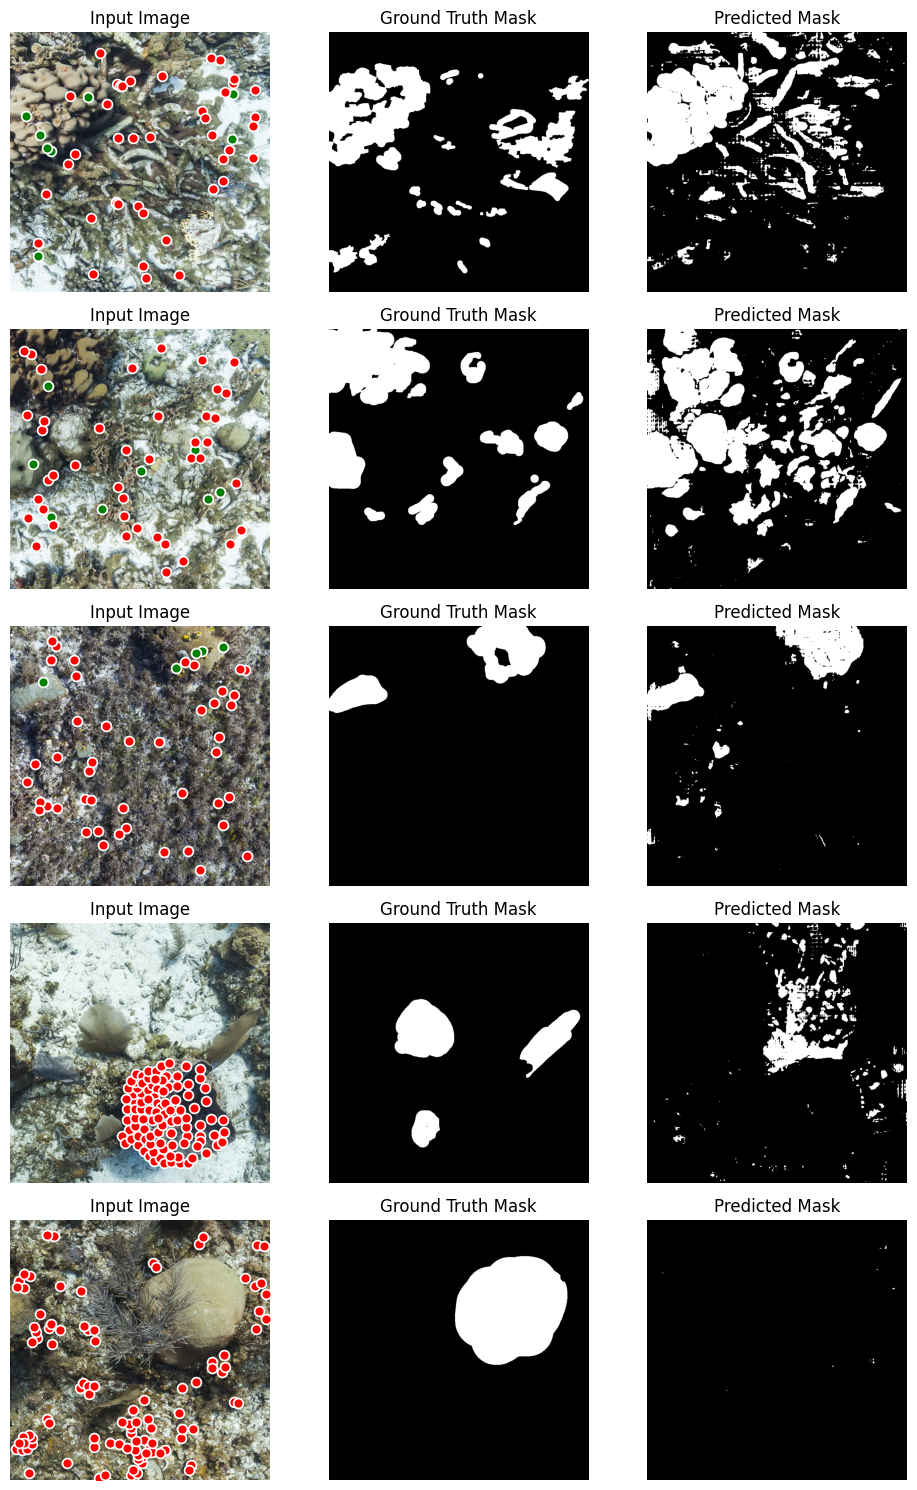

In [ ]:
visualize(model=sam, model_type="SAM", dataset=dl, num_images=5)

In [ ]:
sam_scores = eval_pipeline(dataset=dl, model=sam, model_type='SAM')

  0%|          | 0/483 [00:00<?, ?it/s]

mIoU score for SAM: 0.2280254522024509


### SAM 2

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


def load_sam2_model(model_type="sam2.1_hiera_large", model_cfg="configs/sam2.1/sam2.1_hiera_l.yaml"):
    """
    Loads a SAM2 model from a specified configuration and checkpoint file.

    Parameters:
    -----------
    model_type : str, optional
        Type of SAM2 model to load (e.g., 'sam2.1_hiera_large'). Defaults to 'sam2.1_hiera_large'.

    model_cfg : str, optional
        Idk what/why/how tbh... Defaults to "configs/sam2.1/sam2.1_hiera_l.yaml".

    Returns:
    --------
    SAM2ImagePredictor
        A SAM2ImagePredictor object initialized with the loaded SAM2 model.
    """
    checkpoint = f"../checkpoints/{model_type}.pt"

    sam2_model = build_sam2(model_cfg, checkpoint, device='cuda')
    predictor = SAM2ImagePredictor(sam2_model)
    return predictor


sam2 = load_sam2_model()

In [ ]:
dl = DataLoader(SEAVIEW_PATH)

Loaded 483 images!


  0%|          | 0/18 [00:00<?, ?it/s]

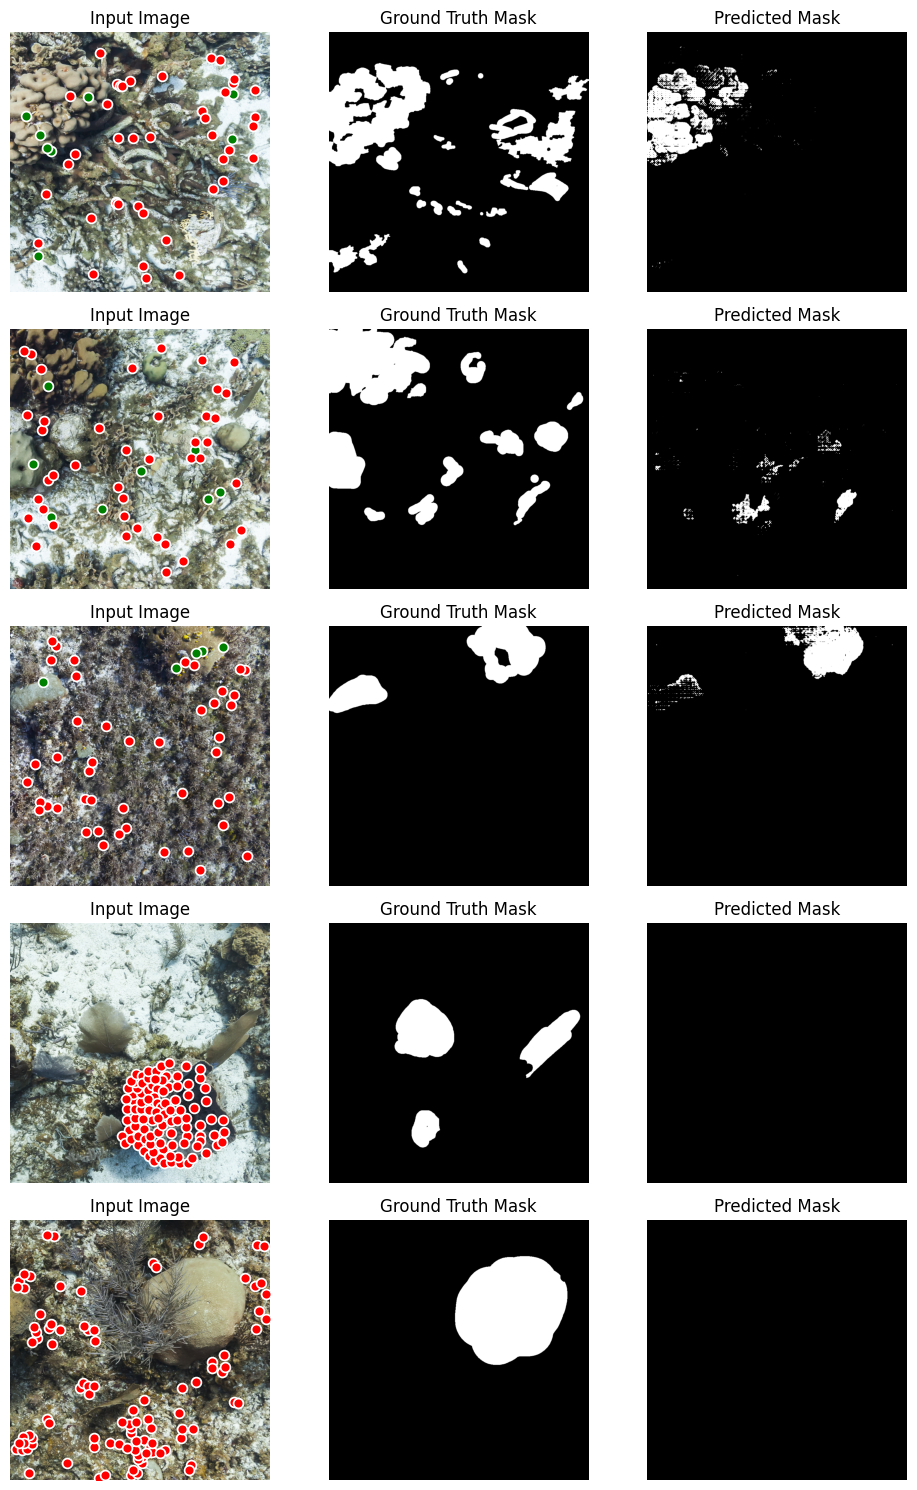

In [ ]:
visualize(model=sam2, model_type="SAM", dataset=dl, num_images=5)

In [ ]:
sam2_scores = eval_pipeline(dataset=dl, model=sam2, model_type='SAM')

  0%|          | 0/483 [00:00<?, ?it/s]

mIoU score for SAM: 0.17092426722867007
